In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
import scipy.stats as stats

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [30]:
def analysis(col):
    temp = train[col].value_counts()
    temp = temp[temp > temp.iloc[0]//100].index
    #temp = train.index
    temp_df = train[train[col].isin(temp)]
    #temp_df = temp_df.sample(10000)
    p = temp_df.HasDetections.mean()
    q = 1-p
    copy = train.copy()
    p_1 = train.HasDetections.mean()
    q_1 = 1-p_1
    random_data = pd.Series(np.random.choice([1,0], len(temp_df),p=[p,q]), index = temp_df.index).rename('HasDetections')
    temp_df['random_data'] = random_data
    random_data_1 = pd.Series(np.random.choice([1,0], len(copy),p=[p_1,q_1]), index = copy.index).rename('HasDetections')
    copy['random_data'] = random_data_1
    
    #temp_df.groupby(col).HasDetections.mean().plot(kind = 'bar', figsize=(20,10))
    temp_df.groupby(col)[['HasDetections', 'random_data']].mean().plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {} (most of the catogaries)'.format(col))
    
    display(pd.DataFrame({'train_data': temp_df.groupby(col).HasDetections.mean(),
                         'random_data': temp_df.groupby(col).random_data.mean()}))
    return stats.ks_2samp(copy.groupby(col).HasDetections.mean(),
                copy.groupby(col).random_data.mean())
                        

In [23]:
COLS = [
    'HasDetections',
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Processor'
]

In [24]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=COLS)

In [25]:
train.head()

,Processor,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,HasDetections
0,x64,4.0,476940.0,0
1,x64,4.0,476940.0,0
2,x64,4.0,114473.0,0
3,x64,4.0,238475.0,1
4,x64,4.0,476940.0,1


In [26]:
#barplot of random_data and chi-square test statiscs over the proportion

#only takes majority of large data to proceed analyis

,train_data,random_data
Census_ProcessorCoreCount,,
1.0,0.295042,0.497272
2.0,0.459875,0.499527
4.0,0.507915,0.499450
6.0,0.566400,0.499027
8.0,0.555008,0.500214
12.0,0.584691,0.497983


Ks_2sampResult(statistic=0.2222222222222222, pvalue=0.1889805563787845)

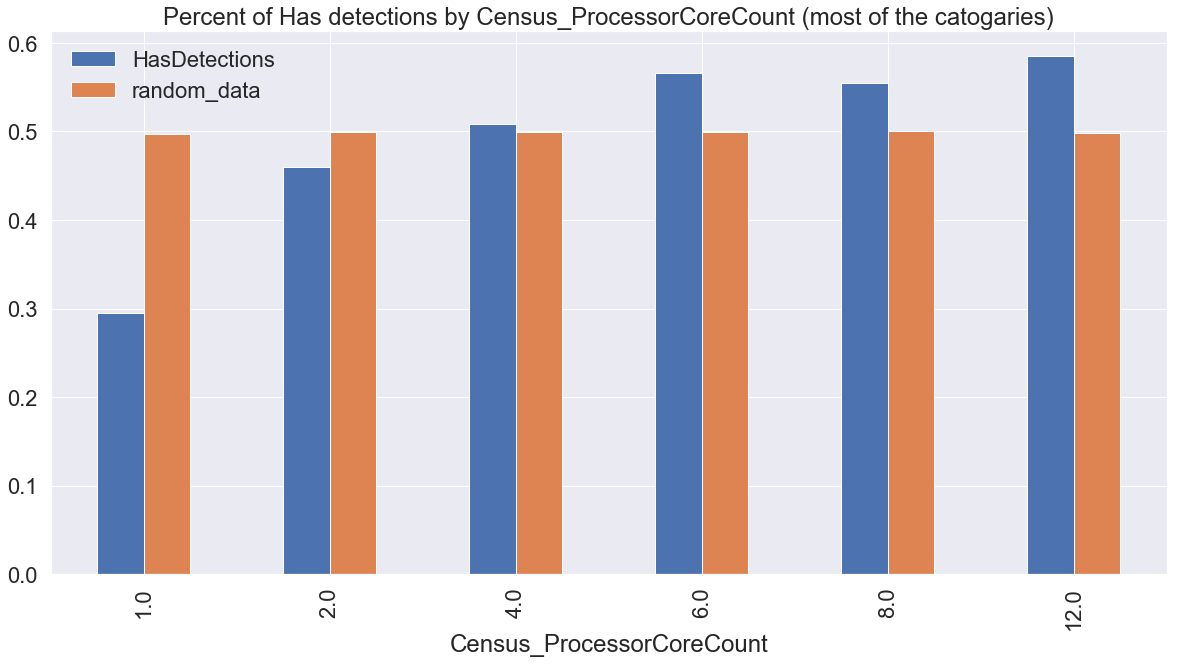

In [32]:
analysis(COLS[1])

,train_data,random_data
Census_PrimaryDiskTotalCapacity,,
29600.0,0.321560,0.506556
29820.0,0.424125,0.505307
29824.0,0.391825,0.503173
59640.0,0.339274,0.504343
114473.0,0.545365,0.506731
122104.0,0.527792,0.504036
152627.0,0.409110,0.505428
228936.0,0.577324,0.502843
238475.0,0.483430,0.505164


Ks_2sampResult(statistic=0.22109851787271145, pvalue=9.76418528903983e-123)

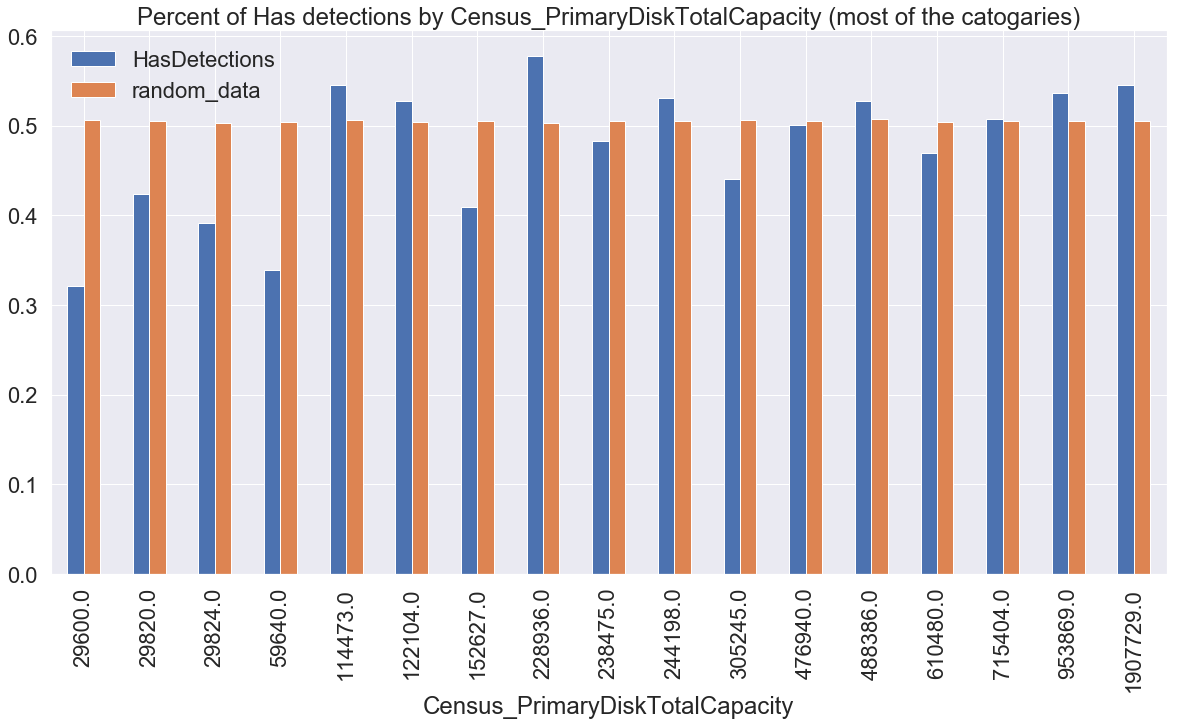

In [33]:
analysis(COLS[2])

,train_data,random_data
Processor,,
x64,0.511446,0.500058
x86,0.384202,0.500888


Ks_2sampResult(statistic=0.6666666666666666, pvalue=0.31972433327096456)

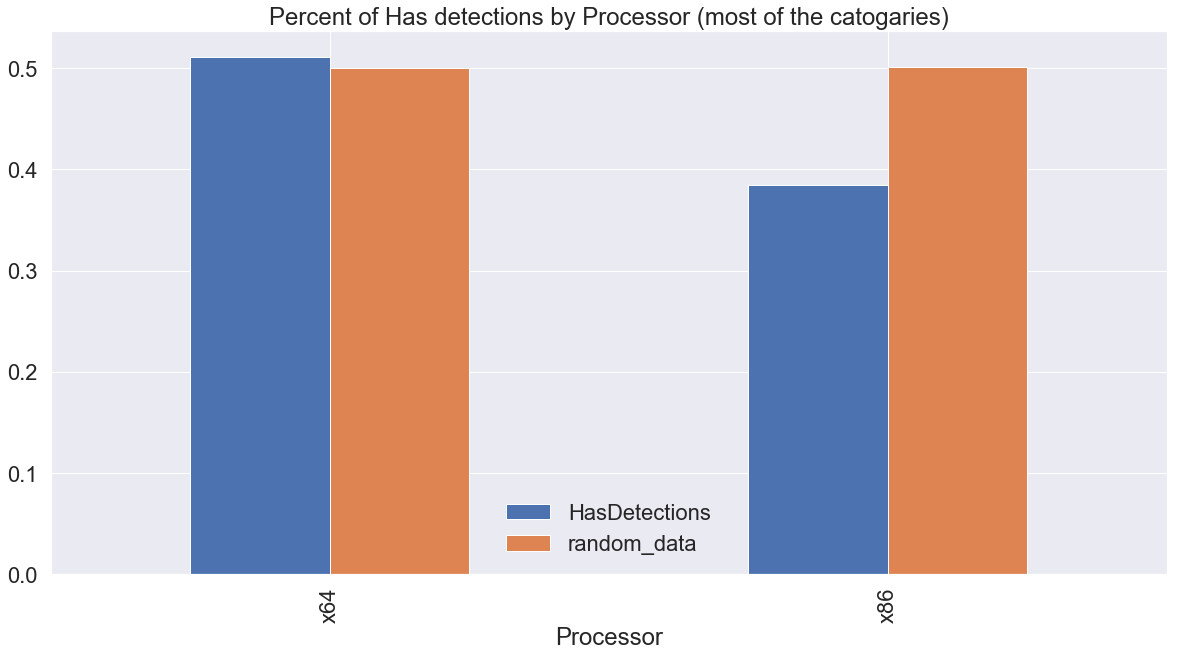

In [31]:
analysis(COLS[3])

In [ ]:
# deep study